In [13]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [14]:
df = pd.read_parquet('..\\..\\data\\fhv_tripdata_2021-01.parquet')
df.head()

dispatching_base_num     pickup_datetime    dropOff_datetime  PUlocationID  \
0               B00009 2021-01-01 00:27:00 2021-01-01 00:44:00           NaN   
1               B00009 2021-01-01 00:50:00 2021-01-01 01:07:00           NaN   
2               B00013 2021-01-01 00:01:00 2021-01-01 01:51:00           NaN   
3               B00037 2021-01-01 00:13:09 2021-01-01 00:21:26           NaN   
4               B00037 2021-01-01 00:38:31 2021-01-01 00:53:44           NaN   

   DOlocationID SR_Flag Affiliated_base_number  
0           NaN    None                 B00009  
1           NaN    None                 B00009  
2           NaN    None                 B00013  
3          72.0    None                 B00037  
4          61.0    None                 B00037

### Q1. Downloading the data
How many records are there?

In [15]:
df.shape[0]

1154112

### Q2. Computing duration

What's the average trip duration in January?

In [16]:
df['duration'] =  df.dropOff_datetime - df.pickup_datetime 
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.mean()

19.1672240937939

In [17]:
# Data preparation
#Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
df = df[(df.duration >= 1) & (df.duration <= 60)]

print(f"we dropped {1154112 - df.shape[0]} rows")


we dropped 44286 rows


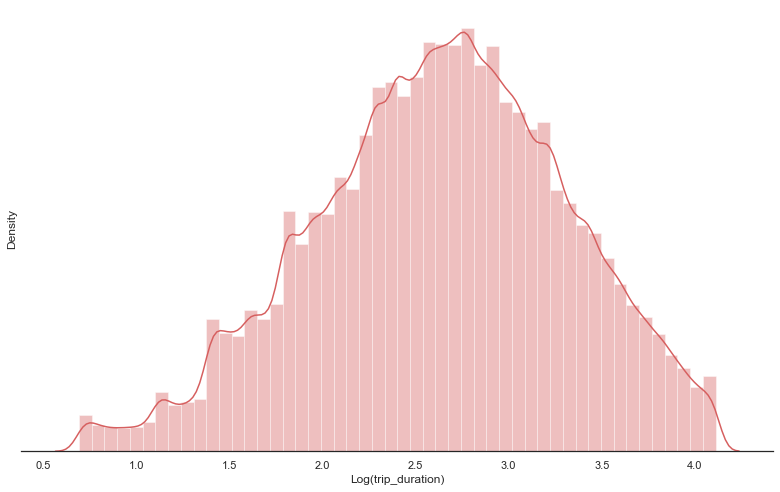

In [18]:
#Plotting ditribution
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(df['duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show();

### Q3. Missing values

What's the factions of missing values for the pickup location ID? (Or the fraction of "-1"s after you filled the NAs)

In [19]:
categorical = ['PUlocationID', 'DOlocationID']

df[categorical] = df[categorical].fillna("-1")
df[categorical] = df[categorical].astype(str)
print(f"portion of  missing values in pickup location ID: {np.round(df[df['PUlocationID'] == '-1'].shape[0] / df.shape[0] * 100,1)}%")


portion of  missing values in pickup location ID: 83.5%


### Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix? (The number of columns)

In [20]:
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f"X_train's dimensionality is equal to {df['PUlocationID'].nunique() + df['DOlocationID'].nunique()}")

X_train's dimensionality is equal to 525


### Q5. Training a model

What's the RMSE on train?

In [21]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f" RMSE on train: {mean_squared_error(y_train, y_pred, squared=False)}")

 RMSE on train: 10.52851910721103


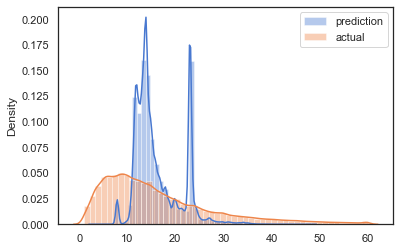

In [22]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend();

In [23]:
df_val = pd.read_parquet('..\\..\\data\\fhv_tripdata_2021-02.parquet')

df_val['duration'] =  df_val.dropOff_datetime - df_val.pickup_datetime 
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)

df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

df_val[categorical] = df_val[categorical].fillna("-1")
df_val[categorical] = df_val[categorical].astype(str)

X_val = dv.transform(df_val[categorical].to_dict(orient='records'))

### Q6. Evaluating the model

What's the RMSE on validation?


In [24]:
y_val = df_val[target].values
y_pred = lr.predict(X_val)



print(f" RMSE on train: {mean_squared_error(y_val, y_pred, squared=False)}")

 RMSE on train: 11.014283190951092


Closest answer: 12.85